In [13]:
import numpy as np
import pandas as pd

from scipy.spatial import distance
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import warnings
import os
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


In [2]:
def plot_clusters(X, model, fit_predict=True):
    # funkcja przedstawiająca wizualizację zbioru danych w 3 wymiarach (pierwsze 3 kolumny)
    # kolorem zaznaczone są klastry przewidziane za pomocą zadanego modelu
    # argument fit_predict mówi, czy model ma metodę fit_predict, czy też predict

    if fit_predict:
        y_pred = model.fit_predict(X)
    else:
        y_pred = model.predict(X)

    ax1 = plt.axes(projection='3d')
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(90,0)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

    ax1 = plt.axes(projection='3d')
    ax1.view_init(0,90)
    ax1.scatter3D(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2], c=y_pred)
    plt.show()

def TSNE_scatter(tsne_model, model, data):
    # funkcja przedstawiająca wizualizację zbioru danych w 2 wymiarach za pomocą metody t-SNE

    x = tsne_model.fit_transform(data)
    colors = model.fit_predict(data)
    palette = np.array(sns.color_palette("hls", 10))

    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

# poniższe funkcje obliczają tzw. metryki interpretowalne
def count_clustering_scores(X, model, score_fun):
    X = X.to_numpy()
    model_instance = model
    labels = model_instance.fit_predict(X)

    return score_fun(X, labels)

def min_interclust_dist(X, label):
    # minimalny dystans pomiędzy klastrami

    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    # średni dystans pomiędzy obserwacjami w jednym klastrze

    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    # średnia z średniego dystansu pomiędzy obserwacjami w jednym klastrze obliczona
    # dla wszystkich klastrów

    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)


def std_dev_of_inclust_dist(X, label):
    # odchylenie standardowe ze średniej odległości pomiędzy punktami w jednym klastrze

    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)


def mean_dist_to_center(X, label):
    # średnia odległość od środka klastra

    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

In [3]:
df = pd.read_csv("../preprocessed_data/preprocessed_pca_train.csv")

In [4]:
def show_results(n_clusters):
    # funkcja przedstawiająca rezultaty metryk interpretowalnych w zależności od liczby klastrów dla
    # różnych modelów agglomerative clustering

    metrices = {
        'min dist between clusters': min_interclust_dist,
        'mean dist in clust': mean_inclust_dist,
        'std dev dist in clust': std_dev_of_inclust_dist,
        'mean dist to clust center': mean_dist_to_center,
        'silhouette': silhouette_score
    }

    models = {
        'Agglomerative ward linkage': AgglomerativeClustering(n_clusters=n_clusters, linkage='ward'),
        'Agglomerative complete linkage': AgglomerativeClustering(n_clusters=n_clusters, linkage='complete'),
        'Agglomerative average linkage': AgglomerativeClustering(n_clusters=n_clusters, linkage='average'),
        'Agglomerative single linkage': AgglomerativeClustering(n_clusters=n_clusters, linkage='single'),
    }

    res = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            res.loc[model_key, metric_key] = count_clustering_scores(X=df, model=models[model_key],
                                                                     score_fun=metrices[metric_key])
    return res

# Agglomerative clustering

## Trening, wizualizacja

### n_clusters=2

Wiązanie "average" dla 2 klastrów


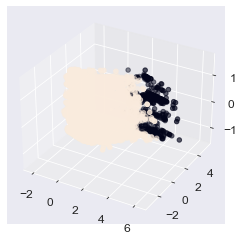

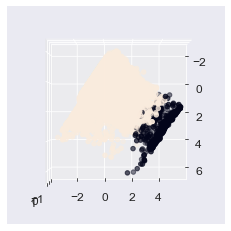

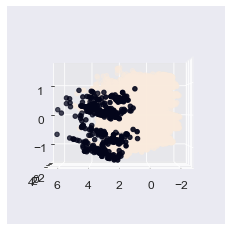

Wiązanie "single" dla 2 klastrów


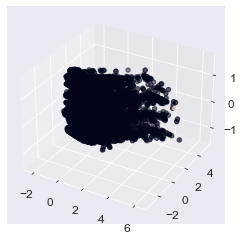

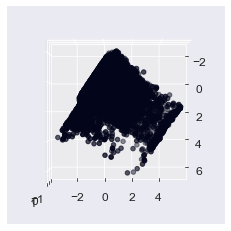

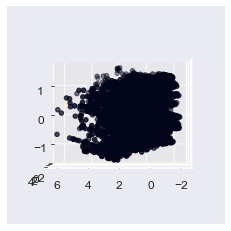

Wiązanie "complete" dla 2 klastrów


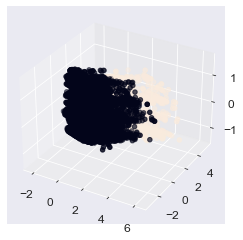

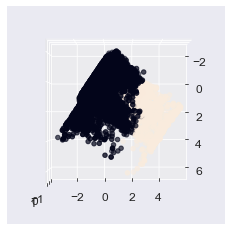

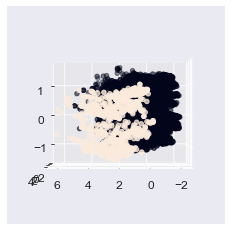

Wiązanie "ward" dla 2 klastrów


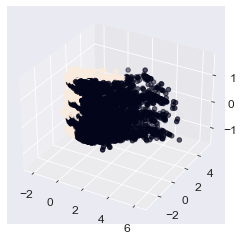

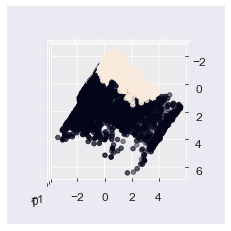

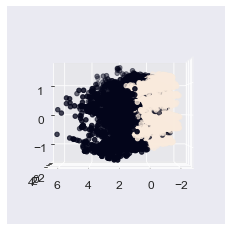

In [6]:
for linkage in {'ward', 'complete', 'average', 'single'}:
    print(f'Wiązanie "{linkage}" dla 2 klastrów')
    plot_clusters(df, AgglomerativeClustering(n_clusters=2, linkage=linkage), True)

In [7]:
show_results(2)

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Agglomerative ward linkage,0.017876,2.096322,0.321754,1.501615,0.203497
Agglomerative complete linkage,0.162196,2.347532,0.191433,1.694995,0.516097
Agglomerative average linkage,0.322275,2.183018,0.031422,1.565899,0.584551
Agglomerative single linkage,1.442168,NaN,NaN,0.826348,0.629416


### n_clusters=3

Wiązanie "average" dla 3 klastrów


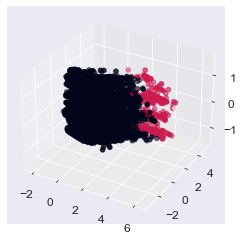

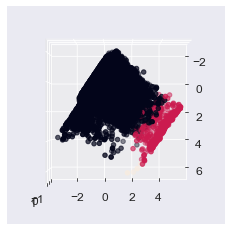

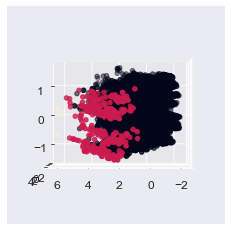

Wiązanie "single" dla 3 klastrów


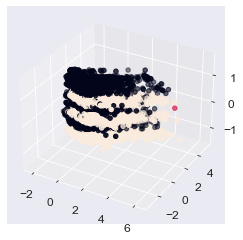

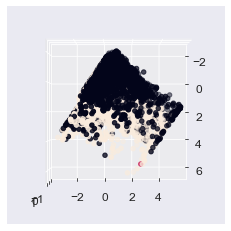

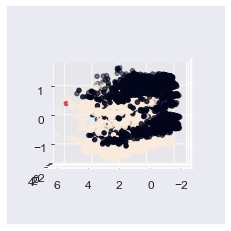

Wiązanie "complete" dla 3 klastrów


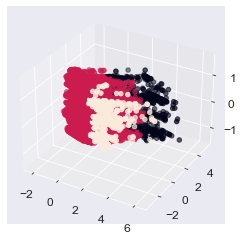

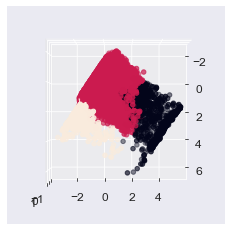

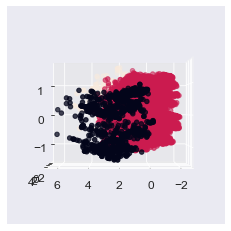

Wiązanie "ward" dla 3 klastrów


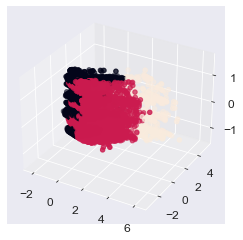

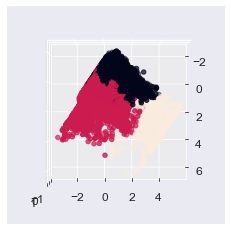

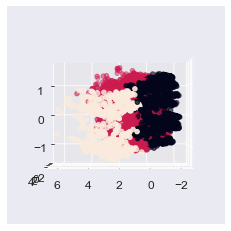

In [8]:
for linkage in {'ward', 'complete', 'average', 'single'}:
    print(f'Wiązanie "{linkage}" dla 3 klastrów')
    plot_clusters(df, AgglomerativeClustering(n_clusters=3, linkage=linkage), True)

In [9]:
show_results(3)

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Agglomerative ward linkage,0.017876,2.082208,0.244878,1.497982,0.214331
Agglomerative complete linkage,0.075974,2.184331,0.258653,1.578450,0.318919
Agglomerative average linkage,0.322275,1.950641,0.304169,1.343974,0.578829
Agglomerative single linkage,1.413956,NaN,NaN,1.001048,0.188893


### n_clusters=4

Wiązanie "average" dla 4 klastrów


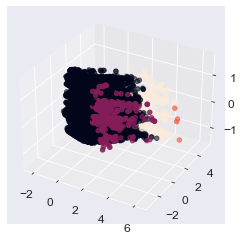

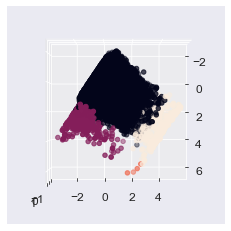

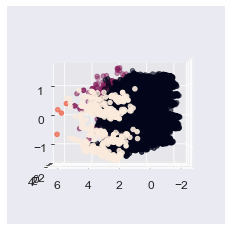

Wiązanie "single" dla 4 klastrów


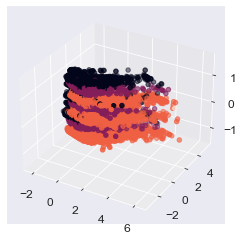

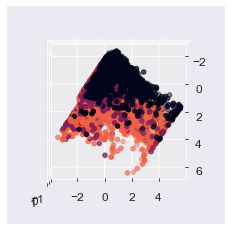

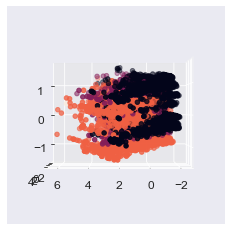

Wiązanie "complete" dla 4 klastrów


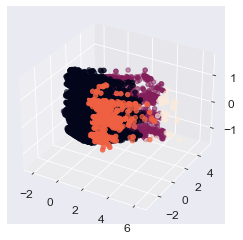

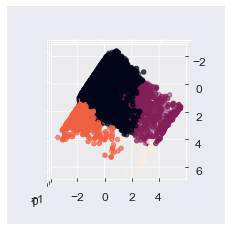

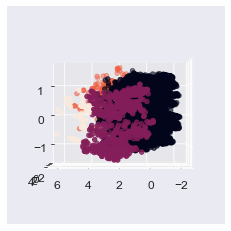

Wiązanie "ward" dla 4 klastrów


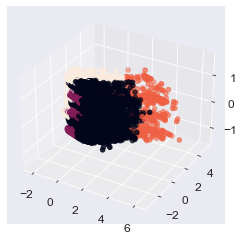

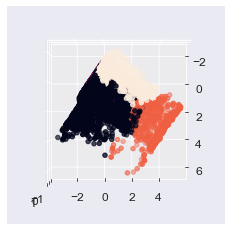

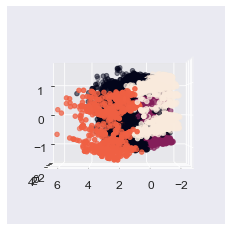

In [10]:
for linkage in {'ward', 'complete', 'average', 'single'}:
    print(f'Wiązanie "{linkage}" dla 4 klastrów')
    plot_clusters(df, AgglomerativeClustering(n_clusters=4, linkage=linkage), True)

In [11]:
show_results(4)

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette
Agglomerative ward linkage,0.017876,1.842001,0.408024,1.329987,0.197597
Agglomerative complete linkage,0.075974,1.989602,0.329584,1.439761,0.308351
Agglomerative average linkage,0.192642,1.940848,0.251287,1.349364,0.394014
Agglomerative single linkage,1.413515,NaN,NaN,1.032609,0.200682


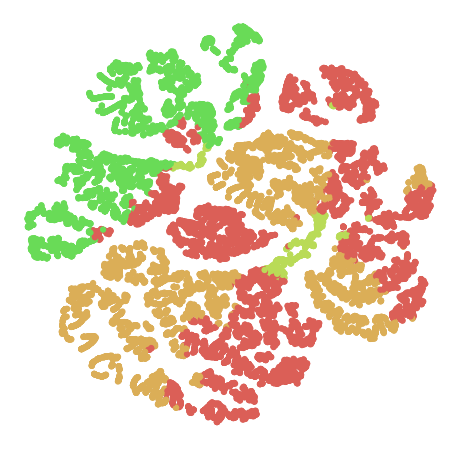

In [14]:
TSNE_scatter(TSNE(n_components=2, random_state=42), AgglomerativeClustering(n_clusters=4, linkage='ward'), df)

## Interpretacja

Postanowiliśmy przyjąć algorytm z 4 klastrami i wiązaniem warda - dzięki 4 klastrom uda nam się być może wyodrębnić i zdefiniować różne grupy klientów

In [15]:
clusters = AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(df)
row_data = pd.read_csv("../data/train.csv")
res_df = row_data.join(pd.DataFrame({'cluster':clusters}))

Dyskretyzujemy wiek i roczny bilans dochodu w celu wizualizacji

In [16]:
def age_group(age):
    if 18 <= age <= 25:
        return '18-25'
    if 25 < age <= 40:
        return '25-40'
    if 40 < age <= 55:
        return '40-55'
    if 55 < age <= 70:
        return '55-70'
    return '70+'
res_df['age'] = res_df['age'].apply(lambda x: age_group(x))

In [17]:
def balance_group(balance):
    if balance < -2000:
        return '-20000:-2000'
    if -2000 <= balance < -1000:
        return '-2000:-1000'
    if -1000 <= balance < 0:
        return '-1000:0'
    if balance == 0:
        return '0'
    if 0 < balance < 1000:
        return '0:1000'
    if 1000 <= balance < 2000:
        return '1000:2000'
    if 2000 <= balance < 4000:
        return '2000:4000'
    if 4000 <= balance < 10000:
        return '4000:10000'
    return '10000:100000'
res_df['balance'] = res_df['balance'].apply(lambda x: balance_group(x))

In [18]:
res_df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster
0,25-40,admin.,single,secondary,no,0:1000,no,no,cellular,29,jan,171,1,-1,0,unknown,no,3
1,40-55,services,married,secondary,yes,0,no,no,telephone,31,jul,35,9,-1,0,unknown,no,0
2,55-70,entrepreneur,married,secondary,no,0:1000,yes,yes,unknown,16,jun,345,4,-1,0,unknown,no,0
3,55-70,technician,married,secondary,no,4000:10000,no,no,telephone,9,feb,167,1,469,1,success,no,0
4,25-40,blue-collar,single,secondary,no,0:1000,no,no,cellular,21,nov,116,1,-1,0,unknown,no,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22147,40-55,management,single,tertiary,no,1000:2000,yes,no,cellular,17,apr,77,1,268,4,other,no,3
22148,40-55,management,single,tertiary,no,2000:4000,yes,no,cellular,18,oct,310,1,804,1,failure,yes,0
22149,25-40,management,married,tertiary,no,-1000:0,yes,no,cellular,28,jan,230,1,204,1,other,no,1
22150,40-55,blue-collar,married,primary,no,0:1000,no,no,unknown,17,jun,114,17,-1,0,unknown,no,1


In [19]:
# liczności klastrów
res_df.cluster.value_counts()

0    9326
1    7165
3    5063
2     598
Name: cluster, dtype: int64

In [20]:
def draw_bar_plots_per(data):
    # funkcja przedstawiająca procentowy udział obserwacji pogrupowanych w klastry dla wybranych zmiennych

    clusters = data.cluster
    columns = ['age', 'balance', 'job', 'education', 'marital', 'default', 'housing', 'loan']

    for column in columns:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()
        counts = data.groupby([column, clusters]).size().unstack()
        proportions = counts.apply(lambda x: x / x.sum(), axis=1)
        proportions.plot(kind='bar', ax=ax)
        plt.show()

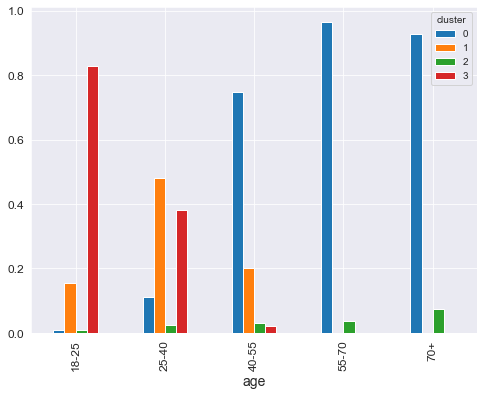

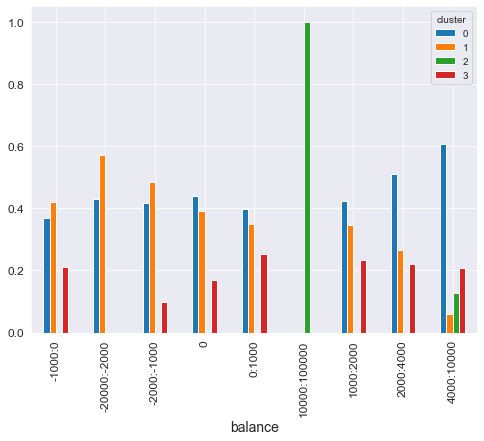

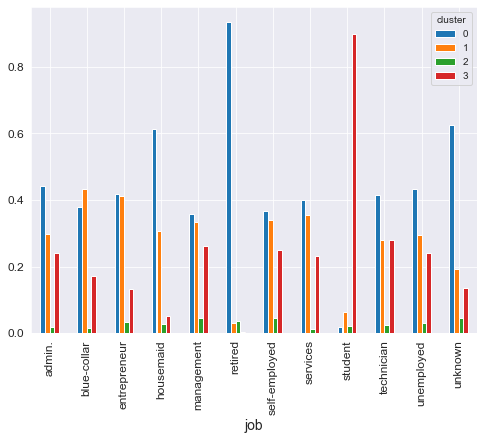

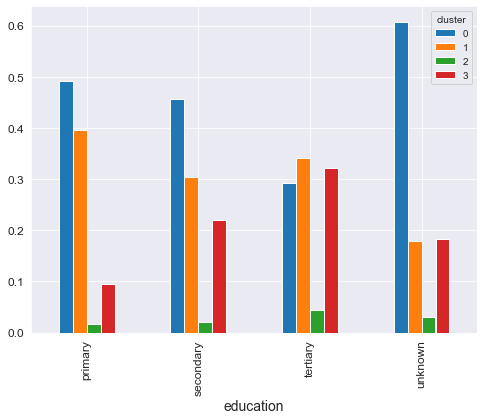

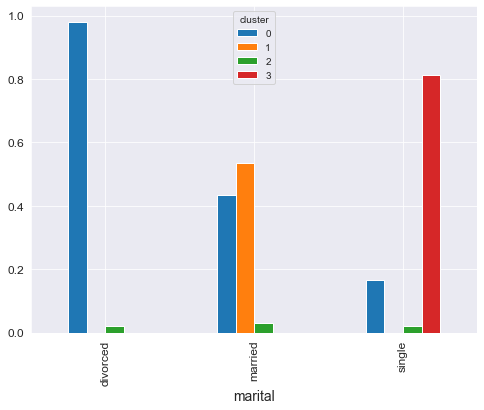

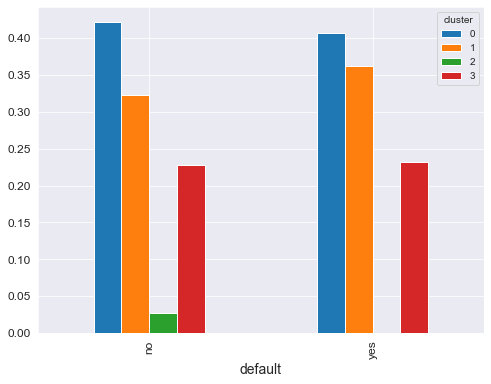

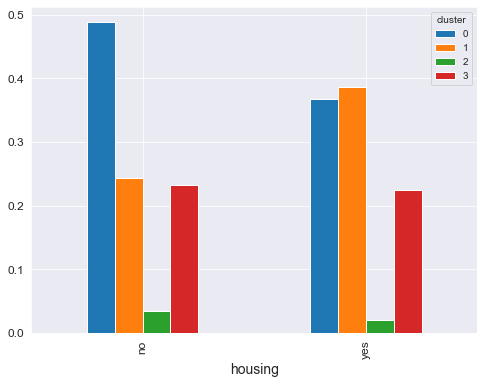

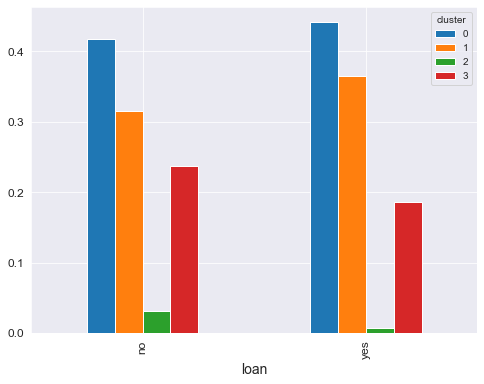

In [21]:
draw_bar_plots_per(res_df)

### Szczegółowa analiza klastrów

In [22]:
row_data = pd.read_csv("../data/train.csv")
res_df = row_data.join(pd.DataFrame({'cluster':clusters}))

In [23]:
res_df.groupby('cluster')['age'].agg(['mean']).sort_values('mean',ascending = False)

,mean
cluster,
0,49.765065
2,43.583612
1,36.153803
3,31.190993


In [24]:
res_df.groupby('cluster')['balance'].agg(['mean']).sort_values('mean',ascending = False)

,mean
cluster,
2,13996.859532
0,1255.832190
3,1012.699783
1,646.665038


In [25]:
res_df.groupby(['cluster', 'default'])['default'].agg(['count'])

count
cluster default       
0       no        9145
        yes        181
1       no        7004
        yes        161
2       no         598
3       no        4960
        yes        103

In [26]:
res_df.groupby(['cluster', 'education'])['education'].agg(['count'])

count
cluster education       
0       primary     1653
        secondary   5226
        tertiary    1875
        unknown      572
1       primary     1328
        secondary   3481
        tertiary    2188
        unknown      168
2       primary       57
        secondary    228
        tertiary     284
        unknown       29
3       primary      318
        secondary   2514
        tertiary    2058
        unknown      173

In [27]:
res_df.groupby(['cluster', 'marital'])['marital'].agg(['count'])

count
cluster marital        
0       divorced   2475
        married    5816
        single     1035
1       married    7165
2       divorced     50
        married     418
        single      130
3       single     5063

In [28]:
res_df.groupby(['cluster', 'job'])['job'].agg(['count']).sort_values(['cluster', 'count'],ascending = False)

count
cluster job                 
3       management      1202
        technician      1037
        blue-collar      823
        admin.           606
        services         485
        student          420
        self-employed    195
        unemployed       148
        entrepreneur      95
        housemaid         32
        unknown           18
        retired            2
2       management       207
        technician        95
        blue-collar       72
        admin.            48
        retired           39
        self-employed     35
        services          26
        entrepreneur      24
        unemployed        19
        housemaid         17
        student           10
        unknown            6
1       blue-collar     2072
        management      1540
        technician      1041
        admin.           749
        services         744
        entrepreneur     294
        self-employed    265
        housemaid        189
        unemployed       183
        retired           33
        student           29
        unknown           26
0       blue-collar     1815
        management      1648
        technician      1543
        admin.          1115
        retired         1044
        services         838
        housemaid        378
        entrepreneur     298
        self-employed    287
        unemployed       268
        unknown           84
        student            8

### Wnioski

In [29]:
df = pd.DataFrame({
    'Grupa': ['0', '1', '2', '3'],
    'Średnia wieku': [48, 36, 50, 31],
    'Średni bilans': [6936, 647, 587, 1016],
    'Stan cywilny': ["W związku małżeńskim/rozwiedziony", "W związku małżeńskim", "W związku małżeńskim/rozwiedziony", "Singiel"],
    'Najpopularniejsze zawody': ["Manager", "Pracownik fizyczny", "Pracownik fizyczny, na emeryturze", "Inżynier, student"]
})

df

,Grupa,Średnia wieku,Średni bilans,Stan cywilny,Najpopularniejsze zawody
0,0,48,6936,W związku małżeńskim/rozwiedziony,Manager
1,1,36,647,W związku małżeńskim,Pracownik fizyczny
2,2,50,587,W związku małżeńskim/rozwiedziony,"Pracownik fizyczny, na emeryturze"
3,3,31,1016,Singiel,"Inżynier, student"


### Podsumowanie - definicja grup klientów

Stosując klasteryzację aglomeracyjną metodą wiązania Warda uzyskaliśmy 4 klastry:

0. Klienci bardzo dobrze zarabiający, w średnim wieku 48 lat i w związku małżeńskim lub po rozwodzie, pracujący na stanowisku menadżerskim.
1. Klienci przeciętnie zarabiający, w średnim wieku 36 lat, w związku małżeńskim, pracujący jako pracownicy fizyczni
2. Klienci przeciętnie zarabiający, w średnim wieku 50 lat, w związku małżeńskim lub po rozwodzie, pracujący jako pracownicy fizyczni lub na emeryturze
3. Klienci dobrze zarabiający, w średnim wieku 31 lat, single, pracujący jako inżynierowie lub studiujący|

### Sprawdzenie dla danych testowych

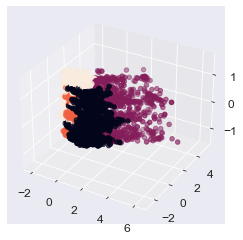

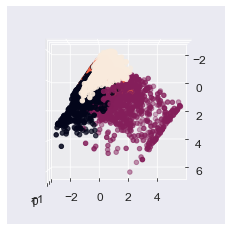

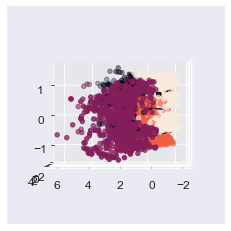

In [30]:
test = pd.read_csv("../preprocessed_data/preprocessed_pca_test.csv")
plot_clusters(test, AgglomerativeClustering(n_clusters=4, linkage='ward'), True)

In [31]:
clusters = AgglomerativeClustering(n_clusters=4, linkage='ward').fit_predict(test)
row_data = pd.read_csv("../data/test.csv")
res_df = row_data.join(pd.DataFrame({'cluster':clusters}))

In [32]:
res_df.groupby('cluster')['age'].agg(['mean']).sort_values('mean',ascending = False)

,mean
cluster,
0,49.635492
1,45.464921
2,35.528534
3,32.690811


In [33]:
res_df.groupby('cluster')['balance'].agg(['mean']).sort_values('mean',ascending = False)

,mean
cluster,
1,7654.729843
2,752.557628
3,670.393626
0,634.898054


In [34]:
res_df.groupby(['cluster', 'default'])['default'].agg(['count'])

count
cluster default       
0       no        3371
        yes         72
1       no         954
        yes          1
2       no        2634
        yes         47
3       no        2368
        yes         48

In [35]:
res_df.groupby(['cluster', 'education'])['education'].agg(['count'])

count
cluster education       
0       primary      490
        secondary   1979
        tertiary     850
        unknown      124
1       primary      183
        secondary    366
        tertiary     352
        unknown       54
2       primary      617
        secondary   1250
        tertiary     704
        unknown      110
3       primary      156
        secondary   1297
        tertiary     871
        unknown       92

In [36]:
res_df.groupby(['cluster', 'marital'])['marital'].agg(['count'])

count
cluster marital        
0       divorced   1014
        married    2370
        single       59
1       divorced     66
        married     650
        single      239
2       married    2681
3       single     2416

In [37]:
res_df.groupby(['cluster', 'job'])['job'].agg(['count']).sort_values(['cluster', 'count'],ascending = False)

count
cluster job                 
3       management       539
        technician       487
        blue-collar      405
        admin.           334
        services         238
        student          159
        self-employed     84
        unemployed        75
        entrepreneur      43
        housemaid         25
        retired           16
        unknown           11
2       blue-collar      885
        management       511
        technician       416
        admin.           262
        services         241
        entrepreneur     108
        self-employed     90
        housemaid         78
        unemployed        58
        unknown           19
        student            7
        retired            6
1       management       265
        blue-collar      171
        technician       129
        admin.            86
        services          74
        retired           71
        self-employed     40
        housemaid         33
        unemployed        31
        entrepreneur      30
        student           16
        unknown            9
0       management       661
        blue-collar      620
        technician       552
        admin.           434
        retired          385
        services         261
        entrepreneur     146
        self-employed    128
        housemaid        123
        unemployed       103
        unknown           30

Nie obserwujemy istotnej różnicy - otrzymaliśmy podobne parametry dla zdefiniowanych grup.